# Counting Molecular Complexes

In [219]:
import numpy as np
import pandas as pd
import panel as pn 
import altair as alt
import tqdm
import prot.viz
prot.viz.altair_theme()
pn.extension('vega')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Data Loading and Pruning
Nathan very bravely scraped EcoCyc for information of the stoichiometry of a large number of biological complexes. Though this list is not yet complete, we can still look through it and make some concrete plots of macromolecular copy numbers as a function of the growth rate. 

In [220]:
# Load the complex subunit counts. 
subunits = pd.read_csv('../../data/compiled_annotated_complexes.csv')

# Load the compiled data 
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')
data['gene_name'] = data['gene_name'].str.lower()

# Compute the minimum number of complexes. 
complex_count = subunits.groupby(['dataset', 'dataset_name', 'condition', 'growth_rate_hr', 'complex_annotation', 'complex'])['n_units'].mean().reset_index()


In [221]:
complex_count.sort_values(by='complex_annotation', inplace=True)
selector = pn.widgets.Select(name='annotated complex', options=list(complex_count['complex_annotation'].unique()), value='1-PFK')
@pn.depends(cplx=selector.param.value)
def plot_cplx(cplx):
    sel_cplx = complex_count[complex_count['complex_annotation']==cplx]
    chart = alt.Chart(sel_cplx, width=500, height=250).mark_point(size=40).encode(
        x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
        y=alt.Y('n_units:Q', axis={'title':'minimimum copy number'}),
        fill='dataset:N',
        stroke=alt.value('black'),
        strokeWidth=alt.value(0.2),
        tooltip=['condition'] 
    ).properties(title=cplx.replace('&alpha;', 'α').replace('&beta;', 'β')).interactive()
    return chart

pn.Column(selector, plot_cplx)

Column
    [0] Select(name='annotated complex', options=['&alpha;-D-xyloside xyloh...], value='&alpha;-D-xyloside x...)
    [1] ParamFunction(function)

## Total Protein Content


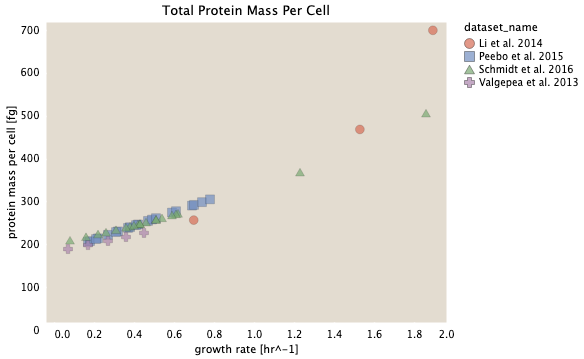

In [222]:
tot_prot_mass = data.groupby(['dataset_name', 'condition', 'growth_rate_hr'])['fg_per_cell'].sum().reset_index()
total_base = alt.Chart(tot_prot_mass)
total_plot = total_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('fg_per_cell:Q', axis={'title':'protein mass per cell [fg]'}),
            fill='dataset_name:N',
            shape='dataset_name:N',
            tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'fg_per_cell:Q', 'tot_per_cell:Q'],
            strokeWidth=alt.value(0.2)
).interactive().properties(title='Total Protein Mass Per Cell')
total_plot.save('../../figures/total_protein_mass.html')
total_plot

## DNA Polymerase

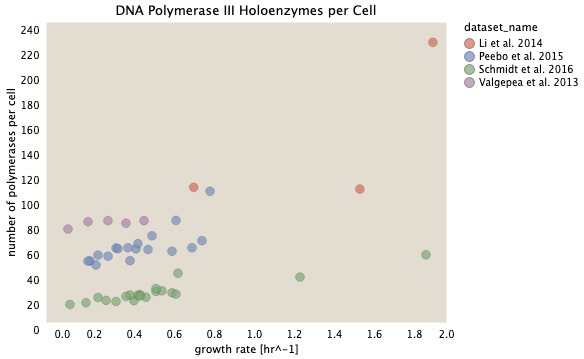

In [223]:
complexes = ['CPLX0-3803']
dna_pol = complex_count[complex_count['complex'].isin(complexes)]
base = alt.Chart(dna_pol)
individuals = base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of polymerases per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='DNA Polymerase III Holoenzymes per Cell')
individuals.save('../../figures/dna_pol.html')
individuals

## RNA Polymerase

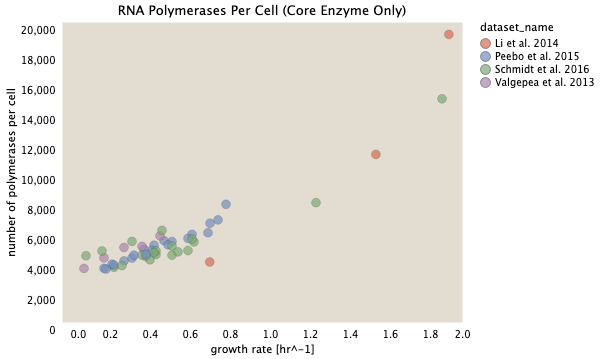

In [224]:
complexes = ['APORNAP-CPLX']
rna_pol = complex_count[complex_count['complex'].isin(complexes)]
base = alt.Chart(rna_pol)
individuals = base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of polymerases per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='RNA Polymerases Per Cell (Core Enzyme Only)')
individuals.save('../../figures/rnap.html')
individuals

## ATP Synthesis 

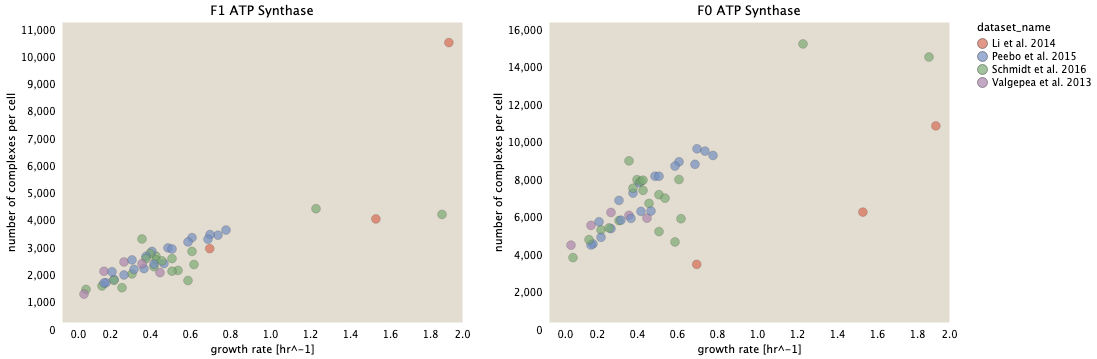

In [225]:
complexes = ['F-1-CPLX', 'F-O-CPLX']
f1 = complex_count[complex_count['complex']=='F-O-CPLX']
f0 = complex_count[complex_count['complex']=='F-1-CPLX']
f1_base = alt.Chart(f1)
f0_base = alt.Chart(f0)
f1f0_base = alt.Chart(f1f0)

f1_individuals = f1_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='F1 ATP Synthase')
f0_individuals = f0_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='F0 ATP Synthase')
fig = f1_individuals | f0_individuals 
fig.save('../../figures/f1f0_atp_synthase.html')
fig

## Ribosomes

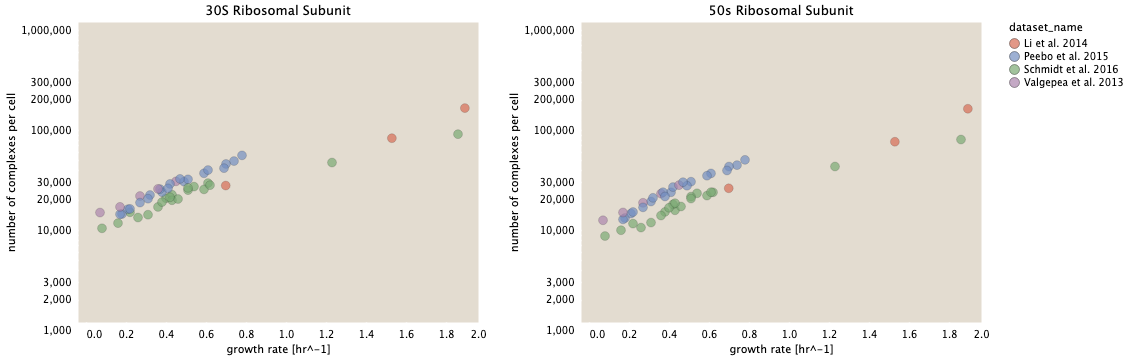

In [228]:
small_sub = complex_count[complex_count['complex']=='CPLX0-3953']
large_sub = complex_count[complex_count['complex']=='CPLX0-3962']
small_base = alt.Chart(small_sub)
large_base = alt.Chart(large_sub)

small_individuals = small_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}, scale={'type':'log'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='30S Ribosomal Subunit')
large_individuals = large_base.mark_point(size=80).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of complexes per cell'}, scale={'type':'log'}),
            fill='dataset_name:N',
            strokeWidth=alt.value(0.2)
).interactive().properties(title='50s Ribosomal Subunit')
fig = small_individuals | large_individuals 
# fig.save('../../figures/f1f0_atp_synthase.html')
fig

##  Sugar transporters

Using the GO term GO:0046323  which is assigned to proteins with putative Glucose import function

In [229]:
pts_system_complexes = ['CPLX-157', 'ASCF-MONOMER', ]
tporters = complex_count[complex_count['complex'].isin(pts_system_complexes)].groupby(
    ['dataset_name', 'condition', 'growth_rate_hr']).sum().reset_index()
tporters['n_units'] = np.round(tporters['n_units'].values)

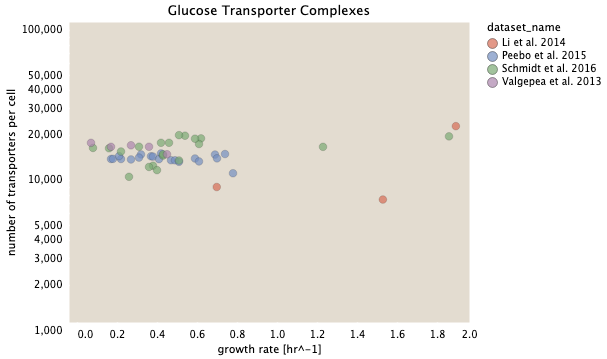

In [230]:
base = alt.Chart(tporters).mark_point(size=60)
min_complex_plot = alt.Chart(tporters).mark_point(size=60).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('n_units:Q', axis={'title':'number of transporters per cell'}, scale={'type':'log'}),
            fill='dataset_name:N',
            tooltip=['condition', 'dataset_name', 'growth_rate_hr', 'n_units'],
            strokeWidth=alt.value(0.2)).properties(title='Glucose Transporter Complexes')

min_complex_plot.save('../../figures/glucose_transporters.html')
min_complex_plot